In [221]:
from pprint import pprint
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import pipeline
from nltk.tokenize import sent_tokenize
import os
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import re
import numpy as np
import plotly.express as px
import json
import requests

In [199]:
from dotenv import load_dotenv

load_dotenv()
folder_path = os.getenv('path_vrubel_letters')
CLIENT_ID = os.getenv('CLIENT_ID')
SCOPE = os.getenv('SCOPE')
AUTH_KEY = os.getenv('AUTH_KEY')

files = os.listdir(folder_path)

## rubert-tiny2-russian-emotion-detection

In [103]:
tokenizer = AutoTokenizer.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')
model = BertForSequenceClassification.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')

In [39]:
LABELS = ['neutral', 'happiness', 'sadness', 'enthusiasm', 'fear', 'anger', 'disgust']

In [104]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

@torch.no_grad()
def predict_emotion(text: str) -> str:
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).detach().cpu().numpy()
    
    return LABELS[predicted[0]]

@torch.no_grad()
def predict_emotions(text: str) -> dict:
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()[0]
    
    return {LABELS[i]: float(prob) for i, prob in enumerate(predicted)}

In [105]:
simple_prediction = predict_emotion("Какой же сегодня прекрасный день, братья")
not_simple_prediction = predict_emotions("Какой же сегодня прекрасный день, братья")

print(simple_prediction)
print(not_simple_prediction)

happiness
{'neutral': 0.0004941819352097809, 'happiness': 0.9979524612426758, 'sadness': 0.00025365984765812755, 'enthusiasm': 0.0005498139071278274, 'fear': 0.0002532619400881231, 'anger': 0.0003583927755244076, 'disgust': 0.00013807787036057562}


In [136]:
results = {}

for i in tqdm(files):
    if '.DS_Store' not in i:
        if 'yyyy' not in i:
            filepath = os.path.join(folder_path, i)
            with open(filepath, 'r') as file:
                text = file.read()
            results[i] = predict_emotions(text)

100%|██████████| 100/100 [00:04<00:00, 21.67it/s]


In [142]:
pprint(results['1872_10_dd_l_AVrubel.txt'])

{'anger': 0.0221044160425663,
 'disgust': 0.001849992899224162,
 'enthusiasm': 0.007311873137950897,
 'fear': 0.007503720000386238,
 'happiness': 0.9554474353790283,
 'neutral': 0.001118793385103345,
 'sadness': 0.00466366671025753}


In [143]:
df = pd.DataFrame(results).T 
df.fillna(0, inplace=True)

df_percentage = df * 100
df_percentage = df_percentage.round(2)

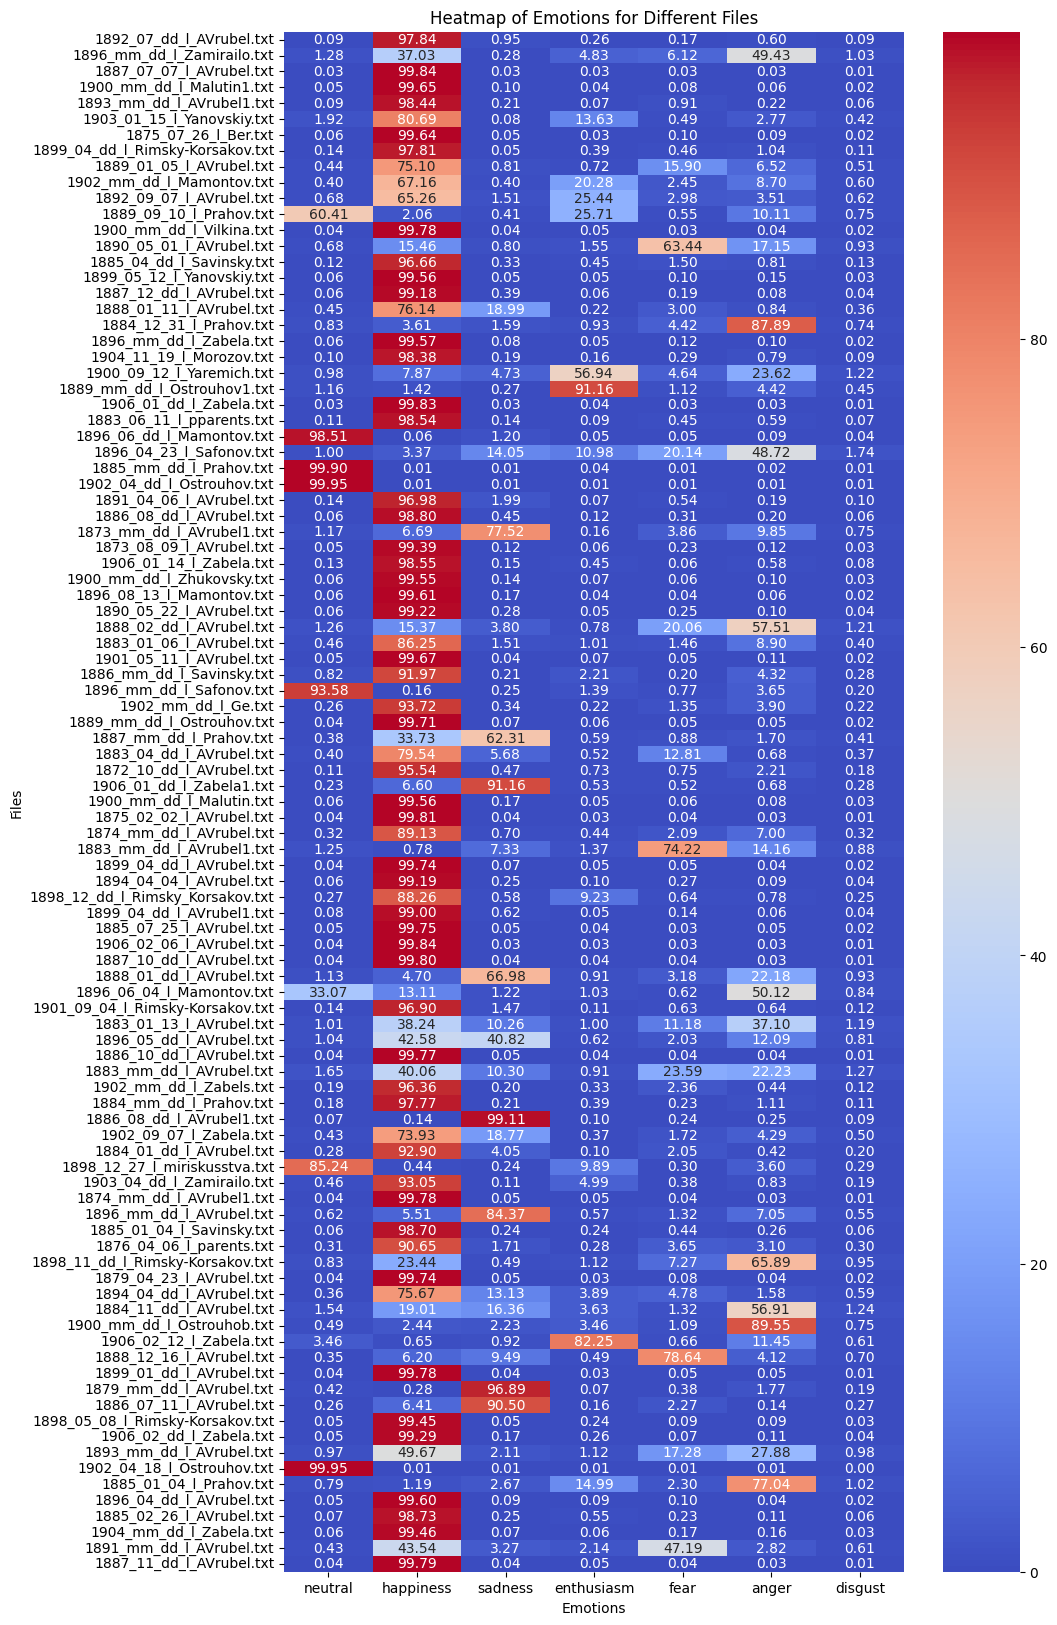

In [ ]:
plt.figure(figsize=(10, 20))
sns.heatmap(df_percentage, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Heatmap of Emotions')
plt.show()

## seara/rubert-tiny2-ru-go-emotions

In [146]:
model = pipeline(model="seara/rubert-tiny2-ru-go-emotions")

Device set to use mps:0


In [149]:
res_dict = {}

for i in tqdm(files):
    results = []
    if '.DS_Store' not in i and 'yyyy' not in i:
        filepath = os.path.join(folder_path, i)
        with open(filepath, 'r') as file:
            text = file.read()
        if len(text) > 2048:
            text1 = text[:2048]
            results.append(model(text1, return_all_scores=True))
        else:
            results.append(model(text, return_all_scores=True))
        res_dict[i] = results

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

100%|██████████| 100/100 [00:05<00:00, 18.11it/s]


In [153]:
res_dict = {}

max_len = 2048

for i in tqdm(files):
    if '.DS_Store' in i or 'yyyy' in i:
        continue

    filepath = os.path.join(folder_path, i)
    with open(filepath, 'r') as file:
        text = file.read()

    chunks = [text[j:j + max_len] for j in range(0, len(text), max_len)]

    all_scores = []

    for chunk in chunks:
        result = model(chunk, return_all_scores=True)[0]  # [0], так как результат завернут в список
        all_scores.append([label_score['score'] for label_score in result])

    avg_scores = np.mean(all_scores, axis=0)

    labels = [label_score['label'] for label_score in result]

    averaged_result = [{'label': label, 'score': float(score)} for label, score in zip(labels, avg_scores)]

    res_dict[i] = [averaged_result]

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:106: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


In [155]:
pprint(res_dict['1872_10_dd_l_AVrubel.txt'])

[[{'label': 'admiration', 'score': 0.27058634255081415},
  {'label': 'amusement', 'score': 0.23000659979879856},
  {'label': 'anger', 'score': 0.04404770815744996},
  {'label': 'annoyance', 'score': 0.07764545734971762},
  {'label': 'approval', 'score': 0.10459044016897678},
  {'label': 'caring', 'score': 0.10524240043014288},
  {'label': 'confusion', 'score': 0.03955875296378508},
  {'label': 'curiosity', 'score': 0.049146514153108},
  {'label': 'desire', 'score': 0.08267359738238156},
  {'label': 'disappointment', 'score': 0.10475256200879812},
  {'label': 'disapproval', 'score': 0.055906503926962614},
  {'label': 'disgust', 'score': 0.07577948458492756},
  {'label': 'embarrassment', 'score': 0.10470416216412559},
  {'label': 'excitement', 'score': 0.11431204294785857},
  {'label': 'fear', 'score': 0.08930723182857037},
  {'label': 'gratitude', 'score': 0.13847760611679405},
  {'label': 'grief', 'score': 0.05708897777367383},
  {'label': 'joy', 'score': 0.29193893633782864},
  {'labe

In [168]:
data = {}
dates = {}

for filename, result in res_dict.items():
    date_str = filename[:10]
    
    try:
        date = datetime.strptime(date_str[:7], "%Y_%m")
    except ValueError:
        date = None 

    emotions = {item['label']: item['score'] * 100 for item in result[0]}
    data[filename] = emotions
    dates[filename] = date

df = pd.DataFrame.from_dict(data, orient='index')

df["__date__"] = df.index.map(dates)
df = df.sort_values("__date__")
df = df.drop(columns="__date__") 

annotations = df.round(0).astype(int).astype(str)

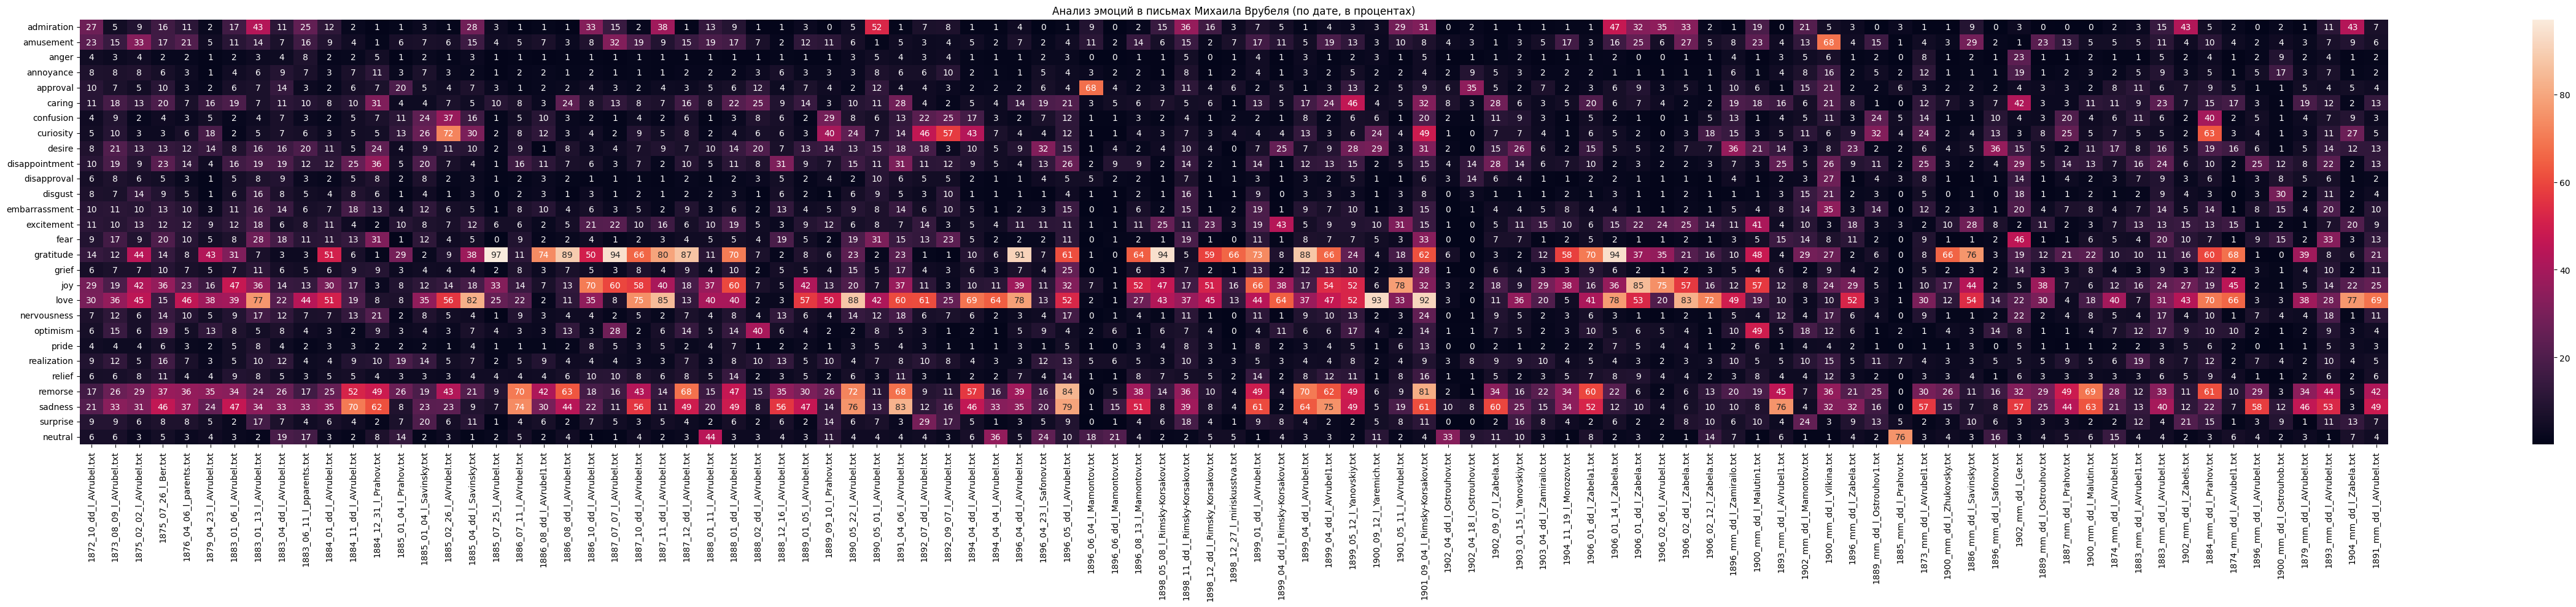

In [169]:
plt.figure(figsize=(len(df) * 0.5, 10))
sns.heatmap(df.T, annot=annotations.T, fmt="", cbar=True)

plt.title("Анализ эмоций в письмах Михаила Врубеля (по дате, в процентах)")
plt.tight_layout()
plt.show()

In [172]:

data = []

for filename, emotions_list in res_dict.items():
    match = re.match(r'(\d{4})', filename)
    if not match:
        continue
    year = int(match.group(1))

    emotion_scores = emotions_list[0] 
    top_emotion = max(emotion_scores, key=lambda x: x['score'])

    data.append({
        'year': year,
        'emotion': top_emotion['label']
    })

df = pd.DataFrame(data)

counts = df.groupby(['year', 'emotion']).size().unstack(fill_value=0)
total_per_year = counts.sum(axis=1)

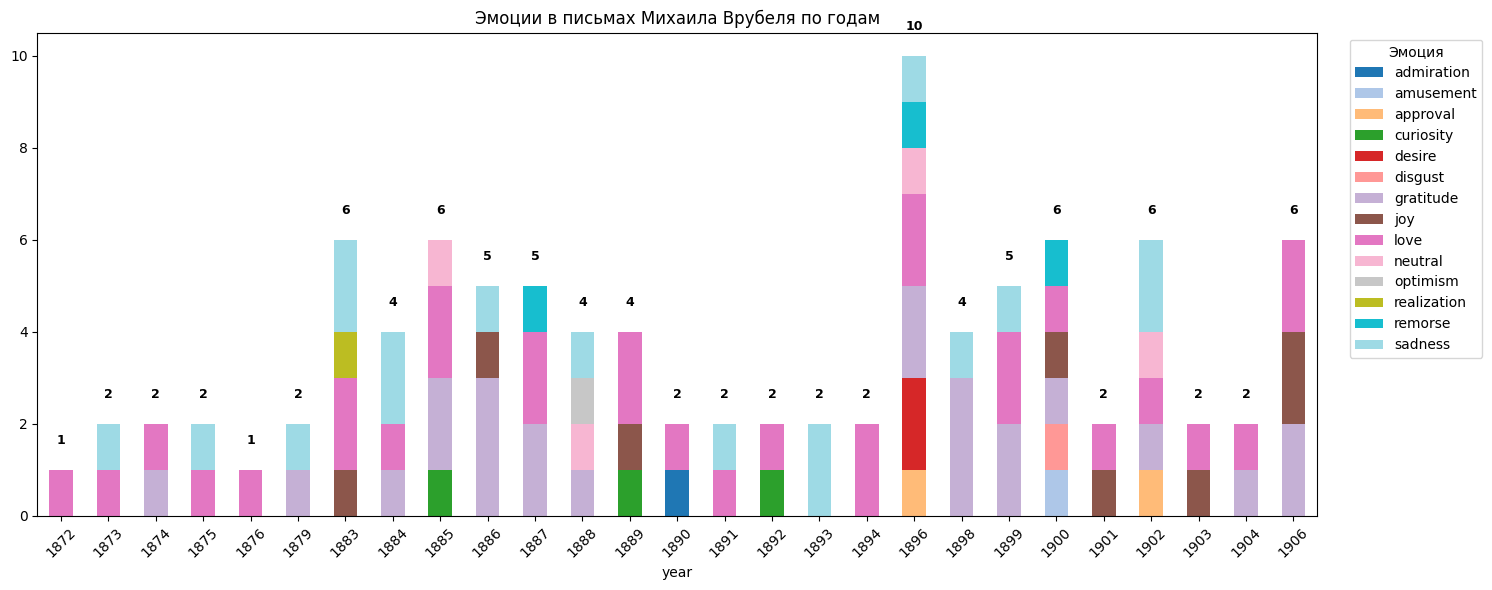

In [173]:
ax = counts.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='tab20')

plt.title('Эмоции в письмах Михаила Врубеля по годам')
plt.legend(title='Эмоция', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)

for i, total in enumerate(total_per_year):
    ax.text(i, total + 0.5, str(total), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [176]:
data = []

for filename, emotions_list in res_dict.items():
    match = re.match(r'(\d{4})', filename)
    if not match:
        continue
    year = int(match.group(1))

    for emotion_data in emotions_list[0]:
        data.append({
            'year': year,
            'emotion': emotion_data['label'],
            'score': emotion_data['score'] * 100
        })

df = pd.DataFrame(data)

In [178]:
fig = px.scatter(
    df,
    x='year',
    y='emotion',
    size='score',
    color='emotion',
    hover_data={'score': ':.1f', 'year': True, 'emotion': True},
    title="Интенсивность эмоций в письмах по годам",
    size_max=30,
)

fig.update_layout(
    xaxis_title="Год",
    yaxis_title="Эмоция",
    xaxis=dict(tickmode='linear', tick0=df['year'].min(), dtick=1, tickangle=45),
    yaxis=dict(categoryorder='total descending')
)

fig.show()

## GigaChat

#### Непонятно, какая модель

In [201]:
from gigachat import GigaChat
from gigachat.models import Chat, Messages, MessagesRole

In [202]:
content=(
                    "Сделай сентимент-анализ текста и оцени его по эмоциям от 1 до 10:\n\n"
                    "admiration: восхищение\n"
                    "amusement: веселье\n"
                    "anger: злость\n"
                    "annoyance: раздражение\n"
                    "approval: одобрение\n"
                    "caring: забота\n"
                    "confusion: непонимание\n"
                    "curiosity: любопытство\n"
                    "desire: желание\n"
                    "disappointment: разочарование\n"
                    "disapproval: неодобрение\n"
                    "disgust: отвращение\n"
                    "embarrassment: смущение\n"
                    "excitement: возбуждение\n"
                    "fear: страх\n"
                    "gratitude: признательность\n"
                    "grief: горе\n"
                    "joy: радость\n"
                    "love: любовь\n"
                    "nervousness: нервозность\n"
                    "optimism: оптимизм\n"
                    "pride: гордость\n"
                    "realization: осознание\n"
                    "relief: облегчение\n"
                    "remorse: раскаяние\n"
                    "sadness: грусть\n"
                    "surprise: удивление\n"
                    "neutral: нейтральность\n\n"
                    "Ответ предоставь в виде словаря. Не пиши никаких комментариев, никакого текста, никакого кода, только словарь.\n\n"
                    f"Текст: {text}"
                )

In [203]:
def question_for_chat(content):
    payload = Chat(
        messages=[
            Messages(
                role=MessagesRole.SYSTEM,
                content = content
            )
        ],
        temperature=0.7,
        max_tokens=300,
    )
    return payload

In [ ]:
result = {}

for i in tqdm(files):
    if '.DS_Store' not in i and 'yyyy' not in i:
        filepath = os.path.join(folder_path, i)
        print(i)
        with open(filepath, 'r') as file:
            text = file.read()
        with GigaChat(credentials=AUTH_KEY, verify_ssl_certs=False) as giga:
            payload = question_for_chat(text)
            payload.messages.append(Messages(role=MessagesRole.USER, content=content))
            response = giga.chat(payload)
            payload.messages.append(response.choices[0].message)
            res_dict = response.choices[0].message.content
            # print(res_dict)
        result[i] = res_dict

In [ ]:
pprint(result)

In [ ]:
with open('emotions_Vrubel.json', 'w', encoding='utf-8') as json_file:
    json.dump(result, json_file, ensure_ascii=False, indent=4)

In [209]:
with open('emotions_Vrubel.json', 'r', encoding='utf-8') as json_file:
    data_loaded = json.load(json_file)

In [214]:
df = pd.DataFrame.from_dict(data_loaded, orient='index').fillna(0)

df_sorted = df.copy()
def extract_date(filename):
    match = re.match(r"(\d{4})_(\d{2}|mm)_(\d{2}|dd)", filename)
    if match:
        year, month, day = match.groups()
        month = '01' if month == 'mm' else month
        day = '01' if day == 'dd' else day
        try:
            return pd.to_datetime(f"{year}-{month}-{day}")
        except:
            return pd.NaT
    return pd.NaT

df_sorted["parsed_date"] = df_sorted.index.map(extract_date)
df_sorted = df_sorted.sort_values("parsed_date")
df_sorted = df_sorted.drop(columns=["parsed_date"])

df_sorted.head()

,admiration,curiosity,excitement,love,optimism,realization,relief,surprise,gratitude,caring,...,sympathy,care,eagerness,trust,kindness,comfort,helpfulness,envy,disapproval,embarrassment
1872_10_dd_l_AVrubel.txt,0.0,7.0,5.0,7.0,0.0,7.0,7.0,7.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1873_mm_dd_l_AVrubel1.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1873_08_09_l_AVrubel.txt,9.0,6.0,8.0,0.0,7.0,8.0,8.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1874_mm_dd_l_AVrubel1.txt,6.0,8.0,5.0,7.0,8.0,9.0,7.0,8.0,7.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1874_mm_dd_l_AVrubel.txt,6.0,5.0,7.0,5.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


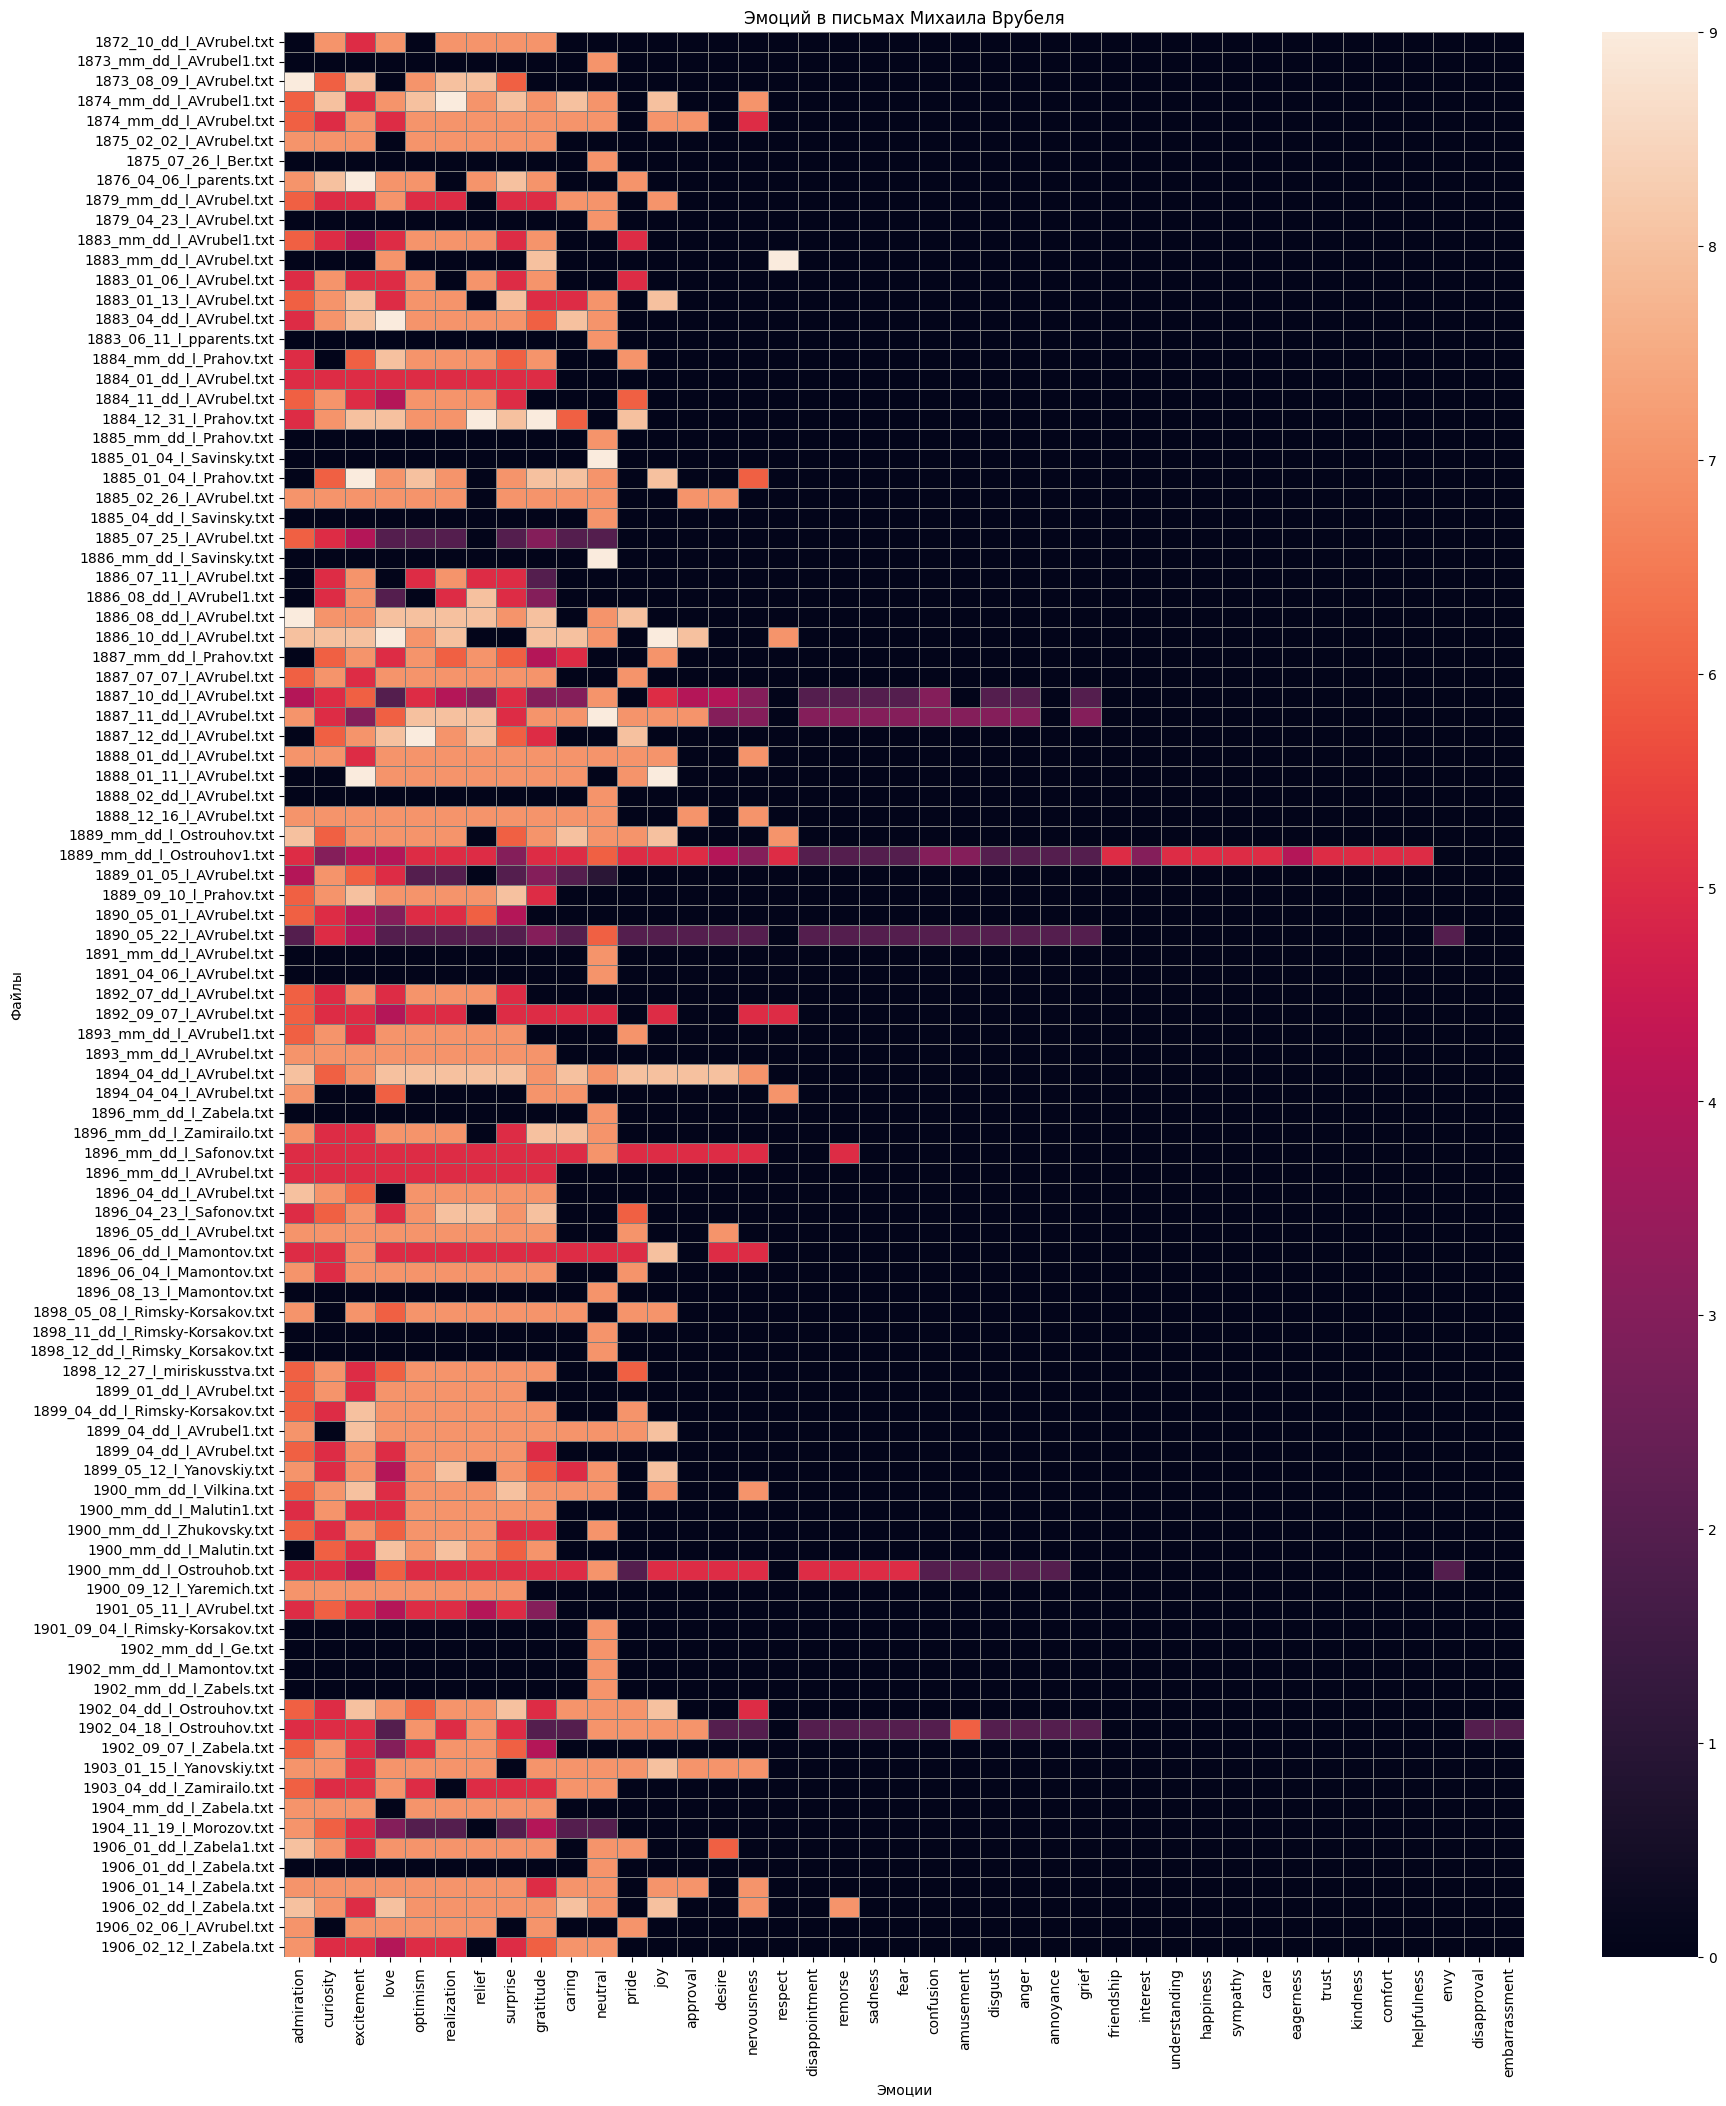

In [215]:
plt.figure(figsize=(20,25))
sns.heatmap(df_sorted, linewidths=0.5, linecolor='gray')
plt.title('Эмоций в письмах Михаила Врубеля')
plt.xlabel('Эмоции')
plt.ylabel('Файлы')

plt.show()

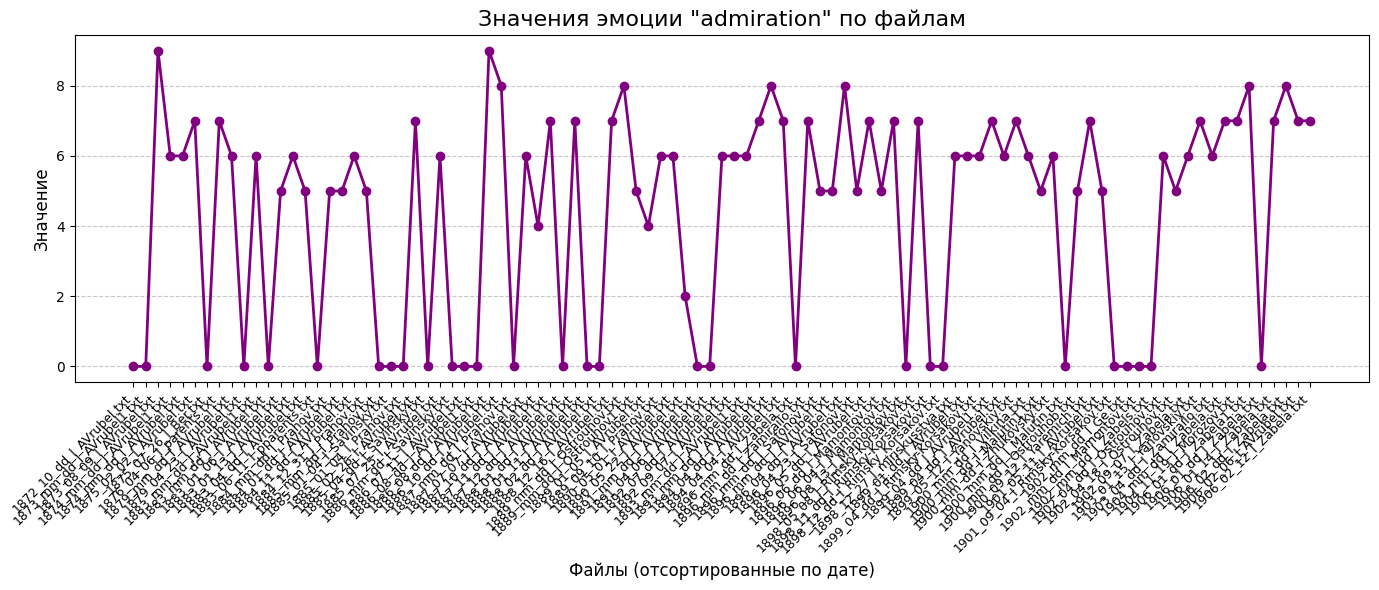

In [220]:
emotion = 'admiration'

plt.figure(figsize=(14,6))
plt.plot(df_sorted.index, df_sorted[emotion], marker='o', linestyle='-', color='purple', linewidth=2, markersize=6)

plt.title(f'Значения эмоции "{emotion}" по файлам', fontsize=16)
plt.xlabel('Файлы (отсортированные по дате)', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [224]:
url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
   'scope': SCOPE
}
headers = {
   'Content-Type': 'application/x-www-form-urlencoded',
   'Accept': 'application/json',
   'RqUID': 'cb7a4161-b5c4-46d8-ad7c-7db7ecc73d12',
   'Authorization': f'Basic {AUTH_KEY}'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)

SSLError: HTTPSConnectionPool(host='ngw.devices.sberbank.ru', port=9443): Max retries exceeded with url: /api/v2/oauth (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)')))